Anomalies detected using kNN with threshold distance > 0.7274800000000016:
     from   to    cost  community  Anomaly
8     235  654   7.281          0     True
110    18  833  10.729          4     True
112   525  438   8.827          4     True
128   767   49   9.985          4     True
135   330   39  14.042          4     True
275   240  683   7.196          8     True
333   518   98   7.349         11     True
359   223  499   8.095         14     True
416   585   36  14.353         16     True
425   591  600   8.862         16     True
472   647  154   9.751         17     True
484   192   52   8.842         17     True
486   154  192  11.022         17     True
521   663  789  17.238         19     True
637   684  296  19.138         23     True
792   264  396  20.539         31     True
829    10  340   9.636         33     True
830   340  696  19.063         33     True
David-Boldin Index: 1.64
Silhouette Score: -0.64


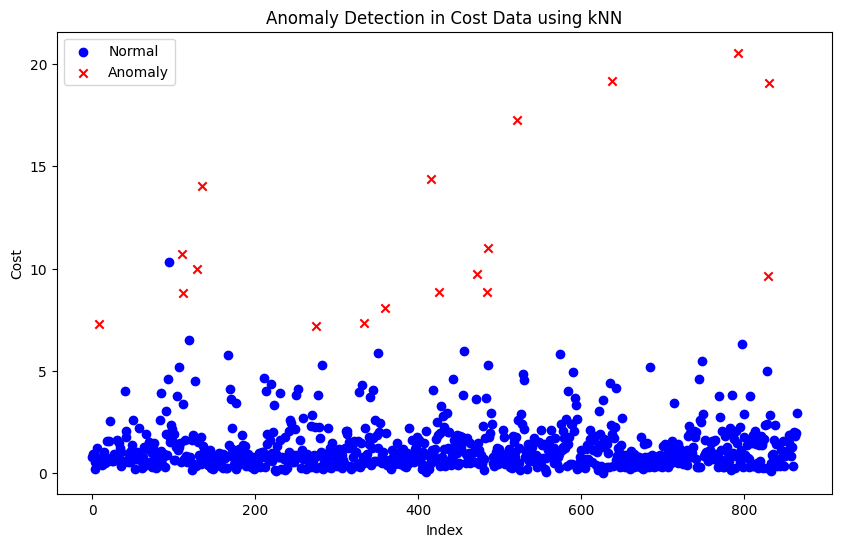

In [1]:
import pandas as pd
import networkx as nx
import community.community_louvain as community_louvain
from scipy.stats import zscore
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors


df = pd.read_csv('../../data/PEMS07/PEMS07.csv')


df.dropna(inplace=True)


G = nx.from_pandas_edgelist(df, 'from', 'to', ['cost'], create_using=nx.DiGraph)


partition = community_louvain.best_partition(G.to_undirected())


for u, v, d in G.edges(data=True):
    d['community'] = partition[u]


data = []

for community in set(partition.values()):
    edges = [(u, v, d['cost']) for u, v, d in G.edges(data=True) if d['community'] == community]
    costs = [cost for _, _, cost in edges]

    if len(costs) < 2:  
        continue

    for u, v, cost in edges:
        data.append({'from': u, 'to': v, 'cost': cost, 'community': community})


df_anomalies = pd.DataFrame(data)


k = 5  
nbrs = NearestNeighbors(n_neighbors=k).fit(df_anomalies[['cost']])
distances, _ = nbrs.kneighbors(df_anomalies[['cost']])


kth_distances = distances[:, k-1]


distance_threshold = np.percentile(kth_distances, 98)  
df_anomalies['Anomaly'] = kth_distances > distance_threshold


print(f"Anomalies detected using kNN with threshold distance > {distance_threshold}:")
print(df_anomalies[df_anomalies['Anomaly']])


total_z_mean = np.mean(np.abs(zscore(df_anomalies['cost'])))
anomalies_z_mean = np.mean(np.abs(zscore(df_anomalies[df_anomalies['Anomaly']]['cost'])))
david_boldin_index = anomalies_z_mean / total_z_mean

print(f'David-Boldin Index: {david_boldin_index:.2f}')


node_costs_labels = pd.DataFrame([(d['cost'], partition[u]) for u, v, d in G.edges(data=True)], columns=['cost', 'community'])

from sklearn.metrics import silhouette_score

silhouette_avg = silhouette_score(node_costs_labels[['cost']], node_costs_labels['community'])
print(f'Silhouette Score: {silhouette_avg:.2f}')


plt.figure(figsize=(10, 6))
normal_points = df_anomalies[df_anomalies['Anomaly'] == False]
anomalies_points = df_anomalies[df_anomalies['Anomaly'] == True]
plt.scatter(normal_points.index, normal_points['cost'], c='blue', marker='o', label='Normal')
plt.scatter(anomalies_points.index, anomalies_points['cost'], c='red', marker='x', label='Anomaly')
plt.xlabel('Index')
plt.ylabel('Cost')
plt.title('Anomaly Detection in Cost Data using kNN')
plt.legend()
plt.show()
